In [1]:
import numpy as np 
import pandas as pd 
import pandas_profiling as pp
import altair as alt
from altair import Chart, X, Y, Axis, SortField
from vega_datasets import data
from altair import expr, datum
from altair.expr import datum
# for the notebook only (not for JupyterLab) run this command once per session
alt.renderers.enable('notebook')
alt.data_transformers.enable('default', max_rows=None) 

DataTransformerRegistry.enable('default')

In [2]:
alt.data_transformers.enable('default', max_rows=None) 

DataTransformerRegistry.enable('default')

In [3]:
df_winter = pd.read_csv('winter.csv')
df_summer = pd.read_csv('summer.csv')
df_sumandwint = pd.read_csv('sumandwint.csv')
df_dictionary = pd.read_csv('dictionary.csv')
ids=pd.read_csv('countryCodes.csv')  

In [4]:
df_dictionary.head()

,Country,Code,Population,GDP per Capita,CountryName,City,CapitalLatitude,CapitalLongitude,CountryCode,ContinentName
0,Afghanistan,AFG,32526562.0,594.323081,Afghanistan,Kabul,34.516667,69.183333,AF,Asia
1,Albania,ALB,2889167.0,3945.217582,Albania,Tirana,41.316667,19.816667,AL,Europe
2,Algeria,ALG,39666519.0,4206.031232,Algeria,Algiers,36.750000,3.050000,DZ,Africa
3,American Samoa*,ASA,55538.0,NaN,American Samoa,Pago Pago,-14.266667,-170.700000,AS,Australia
4,Andorra,AND,70473.0,NaN,Andorra,Andorra la Vella,42.500000,1.516667,AD,Europe


In [5]:
summer_with_country_winner  = pd.merge(df_summer, 
                  df_dictionary[['CountryName','Code', 'CapitalLatitude', 'CapitalLongitude']],
                  left_on='Country',
                  right_on='Code',
                  how='left')
summer_with_country_winner = summer_with_country_winner.drop(['City', 'Sport', 'Country', 'Discipline', 'Athlete','Event', 'Gender', 'Medal'], axis = 1)


In [6]:
summer_filtered = summer_with_country_winner.groupby(['Year', 'Code', 'CapitalLatitude', 'CapitalLongitude']).count().reset_index()
summer_filtered.columns = ['Year', 'Three_Letter_Country_Code', 'Latitude', 'Longitude', 'Quantity']
summer_filtered.head()

,Year,Three_Letter_Country_Code,Latitude,Longitude,Quantity
0,1896,AUS,-35.266667,149.133333,2
1,1896,AUT,48.200000,16.366667,5
2,1896,DEN,55.666667,12.583333,6
3,1896,FRA,48.866667,2.333333,11
4,1896,GBR,51.500000,-0.083333,7


In [7]:
quantity_ids = summer_filtered.groupby('Three_Letter_Country_Code')['Quantity'].agg(['sum']).reset_index()

In [8]:
new_quantity_ids = pd.merge(
                  ids,
                  quantity_ids,
                  on='Three_Letter_Country_Code',
                  how='left')
new_quantity_ids = new_quantity_ids.rename(columns={"sum": "Total"})
new_quantity_ids = new_quantity_ids.fillna(0)
new_quantity_ids.head()

,continent,Continent_Code,Country_Name,Two_Letter_Country_Code,Three_Letter_Country_Code,Country_Number,Total
0,Asia,AS,"Afghanistan, Islamic Republic of",AF,AFG,4.0,2.0
1,Europe,EU,"Albania, Republic of",AL,ALB,8.0,0.0
2,Antarctica,AN,Antarctica (the territory South of 60 deg S),AQ,ATA,10.0,0.0
3,Africa,AF,"Algeria, People's Democratic Republic of",DZ,ALG,12.0,15.0
4,Asia,OC,American Samoa,AS,ASM,16.0,0.0


In [9]:
new_ids = pd.merge(summer_filtered,
                  ids,
                  on='Three_Letter_Country_Code',
                  how='left')
new_ids.head()

,Year,Three_Letter_Country_Code,Latitude,Longitude,Quantity,continent,Continent_Code,Country_Name,Two_Letter_Country_Code,Country_Number
0,1896,AUS,-35.266667,149.133333,2,Asia,OC,"Australia, Commonwealth of",AU,36.0
1,1896,AUT,48.200000,16.366667,5,Europe,EU,"Austria, Republic of",AT,40.0
2,1896,DEN,55.666667,12.583333,6,Europe,EU,"Denmark, Kingdom of",DK,208.0
3,1896,FRA,48.866667,2.333333,11,Europe,EU,"France, French Republic",FR,250.0
4,1896,GBR,51.500000,-0.083333,7,Europe,EU,United Kingdom of Great Britain & Northern Ire...,GB,826.0


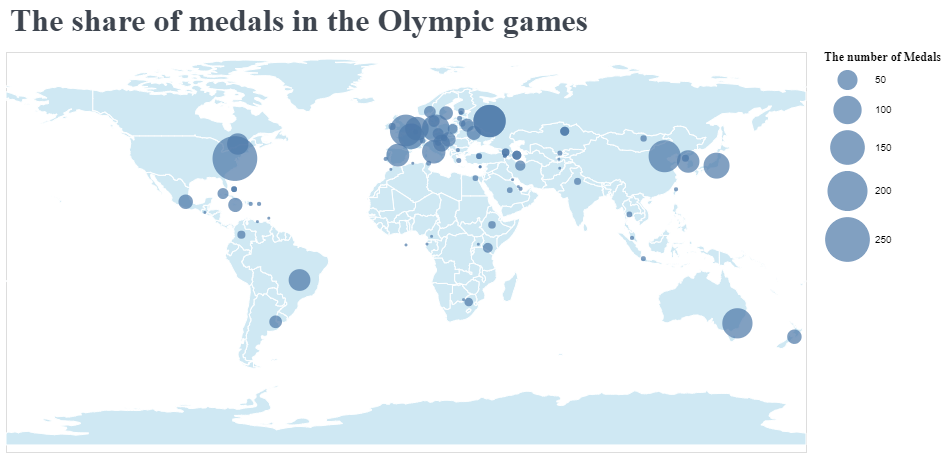

In [10]:
slider = alt.binding_range(min=1896, max=2012, step=4, name='Year:')
select_year = alt.selection_single(name="Year", fields=['Year'], bind=slider, init={'Year': 2012})

countries = alt.topo_feature(data.world_110m.url, 'countries')
country_selection = alt.selection_single(name="Country_Name", fields=['Country_Name'], on='mouseover')

geomap = alt.Chart(countries).mark_geoshape(
    fill='#cfe8f3',
    stroke='white'
).encode().transform_lookup(
    lookup="id",
    from_ = alt.LookupData(new_ids, 'Country_Number', ['Quantity'])
).add_selection(
  country_selection
).properties(
    width=800,
    height=400
).project(
    type='equirectangular'
)

points = alt.Chart(new_ids).mark_circle().encode(
    longitude='Longitude:Q',
    latitude='Latitude:Q',
    size=alt.Size('Quantity:Q',scale=alt.Scale(range=[0, 2000]), legend=alt.Legend(title="The number of Medals", titleFont='Lato Regular Italic', titleFontSize=12)),
    tooltip=['Country_Name', 'Quantity']
).add_selection( 
    select_year
).transform_filter(
    select_year
).properties(
    width=800,
    height=400,
    title = 'The share of medals in the Olympic games'
)
(geomap + points).configure_title(
    fontSize=32,
    font='Lato Bold',
    anchor='start',
    color='#3E454F',
    dx=5,
    dy=-10
)

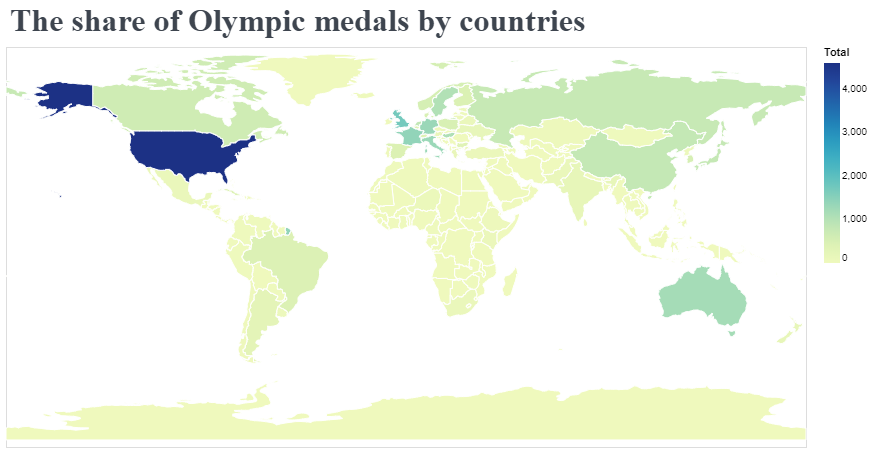

In [11]:
countries = alt.topo_feature(data.world_110m.url, 'countries')
country_selection = alt.selection_single(name="Country_Name", fields=['Country_Name'], on='mouseover')

alt.Chart(countries).mark_geoshape(
    fill='#cfe8f3',
    stroke='white'
).encode(
    tooltip = alt.Tooltip(['Country_Name:N', 'id:N', 'Total:N']),
    color='Total:Q'
).transform_lookup(
    lookup="id",
    from_ = alt.LookupData(new_quantity_ids, 'Country_Number', ['Country_Name', 'Total'])
).configure_title(
    fontSize=32,
    font='Lato Bold',
    anchor='start',
    color='#3E454F',
    dx=5,
    dy=-5
).properties(
    width=800,
    height=400,
    title = 'The share of Olympic medals by countries'
).project(
    type='equirectangular'
)